# HOMER DATA PROCESSING SCRIPT
The goal of this script is to take the output file of HOMER Pro Batch Runs (.xlsx file containing one optimal case/sheet) and produce a condensed data set + plots.

General flow:
1) Run HOMER study via batch process. Select "export results" and name the file.


2) Import file to this script.


3) Use Pandas to pull .xlsx data into a more usable format. 


4) Use collected data to build plots. 

Goals:


Have this script take a large HOMER study (>100 cases) and build one easily accessible database.


Potentially couple this script with a HOMER input reading script to do cartography w/HOMER geography + results.


In [6]:
# Block of dependencies and working directory
import matplotlib.pyplot as plt
import conda
import numpy  as np 
import pandas as pd
import os 
import shutil
directory = 'd:/repo/homer/ClimateStudies/OutputProcessing/Data' #home PC
#directory = 'c:/repo/homer/ClimateStudies/OutputProcessing/Data' #laptop

## Following this guide for xlsx reading
https://stackoverflow.com/questions/26521266/using-pandas-to-pd-read-excel-for-multiple-worksheets-of-the-same-workbook

In [7]:
# reads, maps all sheets 
files = os.listdir(directory)
output_df = {} #creates empty dictionary
names = [] #creates empty list for future name storage
for file in files:
    if file.endswith('.xlsx'):
        xls = pd.ExcelFile(directory + '/' + file) #reads file
        names = names + xls.sheet_names
        for sheet_name in xls.sheet_names: #pulls individual sheets
            output_df[sheet_name] = xls.parse(sheet_name) #puts each sheet into a dictionary w/key "sheet_name"
#display(output_df[sheet_name])

In [26]:
#pulling interesting data points from each 
opt_out = pd.DataFrame(columns=['Architecture/PV\n(kW)', 'Architecture/G1500', 'Architecture/GenLarge\n(kW)', 'Architecture/1kWh LI',
                                                 'Cost/COE\n($)','GenMin'])
new_cases = pd.DataFrame(columns=['FileName','CaseNum','Cost/COE\n($)','Architecture/GenLarge\n(kW)'])
n = len(names)
for i in range(n):
    name = names[i] # Grabs Sheet Name
    KCC = name[-3:]     #grabs KCC from last 3 values
    if KCC[-2:].casefold() == ('Af'.casefold()):
            KCC = 'Af'
            Location = name[5:-2]
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                case_num = name[:6] # Grabs Case Number 
            else:
                case_num = name[:5]
    elif KCC[-2:].casefold() == 'Am'.casefold():
            KCC = 'Am'
            Location = name[5:-2]
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                case_num = name[:6] # Grabs Case Number 
            else:
                case_num = name[:5]
    else: 
            Location = name[5:-3]
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                case_num = name[:6] # Grabs Case Number 
            else:
                case_num = name[:5]
    KCC = KCC.lower()
    filtered_out = output_df[name].filter(['Architecture/PV\n(kW)', 'Architecture/G1500', 'Architecture/GenLarge\n(kW)', 'Architecture/1kWh LI',
                                                 'Cost/COE\n($)']) #Filtering objects of interest
    filtered_out['CaseName'] = Location #adding actual case name to series
    filtered_out['CaseNum'] = case_num # adding case num to series
    filtered_out['KCC'] = KCC
    framed = filtered_out.iloc[[0]] #making the actual df
    framed.set_index(['CaseNum','CaseName'], inplace=True, drop=True) #building df w/ casename and num
    opt_out = pd.concat([framed,opt_out]) #concating all DFs together
    temp = pd.DataFrame(columns=['FileName','CaseNum','Cost/COE\n($)','Architecture/GenLarge\n(kW)'])
    if opt_out.loc[case_num].loc[Location].loc['Architecture/GenLarge\n(kW)'] >= 2000:
        #display('This is working')
        opt_out.loc[case_num].loc[Location].loc['GenMin'] = 'False' #flags case for further cost increases
        if case_num == 'Case4':
            #shutil.copyfile('d:/repo/homer/ClimateStudies/ProductionCases/Case4/' + name + '.homer', directory + '/NewCase/' + 'Case5' + name[5:] + '.homer')
            temp.loc['FileName'] = name
            temp['CaseNum'] = case_num
            temp.set_index(['FileName'],drop=True,inplace=True) #
            temp['Cost/COE\n($)'] = opt_out.loc[case_num].loc[Location].loc['Cost/COE\n($)']
            temp['Architecture/GenLarge\n(kW)'] = opt_out.loc[case_num].loc[Location].loc['Architecture/GenLarge\n(kW)']
            #display(temp)
    elif case_num == 'Case1':
        temp.loc['FileName'] = name
        temp['CaseNum'] = case_num
        temp.set_index(['FileName'],drop=True,inplace=True) #
        temp['Cost/COE\n($)'] = opt_out.loc[case_num].loc[Location].loc['Cost/COE\n($)']
        temp['Architecture/GenLarge\n(kW)'] = 0
    else: 
        opt_out.loc[case_num].loc[Location].loc['GenMin'] = 'True' #nuclear cost is "maxed out"
    new_cases = pd.concat([temp,new_cases])
    
# Data Cleanup    
opt_out = opt_out[ ['KCC'] + [ col for col in opt_out.columns if col != 'KCC' ] ] #sorting df to have KCC first
opt_out = opt_out.sort_index()
opt_out.to_excel("LocationalVarianceTrimmed.xlsx")
new_cases.to_excel("NewCaseData.xlsx")
#display(opt_out)
display(new_cases)

,CaseNum,Cost/COE\n($),Architecture/GenLarge\n(kW),FileName
Case4WadenaMNDfa,Case4,0.138689,3000.0,NaN
Case4VegasNVBwh,Case4,0.155194,3000.0,NaN
Case4UPMichDfb,Case4,0.162385,3000.0,NaN
Case4TexasOilBSh,Case4,0.132140,2000.0,NaN
Case4SyracuseDfb,Case4,0.178524,3000.0,NaN
...,...,...,...,...
Case1BendOreBsk,Case1,0.233693,0,NaN
Case1BangorMEDfb,Case1,0.302428,0,NaN
Case1AtlantaGACfa,Case1,0.252569,0,NaN
Case1AshlandDfb,Case1,0.207777,0,NaN


In [9]:
#for index = opt_out.ind
#display(pd.MultiIndex.get_level_values(opt_out('CaseNum')))
Case1 = opt_out.loc[("Case1",slice(None))]
Case2 = opt_out.loc[("Case2",slice(None))]
Case25 = opt_out.loc[("Case25",slice(None))]
Case3 = opt_out.loc[("Case3",slice(None))]
Case35 = opt_out.loc[("Case35",slice(None))]
Case4 = opt_out.loc[("Case4",slice(None))]
display(Case4)
#Case1.plot(y='Cost/COE\n($)', use_index=True)

,KCC,Architecture/PV\n(kW),Architecture/G1500,Architecture/GenLarge\n(kW),Architecture/1kWh LI,Cost/COE\n($),GenMin
CaseName,,,,,,,
AZYuma,bwh,18946.593167,2.0,3000.0,34290,0.159500,NaN
Anchorage,dfc,21000.218750,NaN,4000.0,27500,0.201563,NaN
Ashland,dfb,28267.444075,8.0,3000.0,32379,0.171955,NaN
AtlantaGA,cfa,14683.409012,3.0,4000.0,26473,0.189311,NaN
BangorME,dfb,14034.944807,5.0,4000.0,27169,0.193386,NaN
...,...,...,...,...,...,...,...
Syracuse,dfb,32226.588138,6.0,3000.0,31696,0.178524,NaN
TexasOil,bsh,12331.998758,7.0,2000.0,35767,0.132140,NaN
UPMich,dfb,24484.569835,7.0,3000.0,34867,0.162385,NaN


<Figure size 432x288 with 0 Axes>

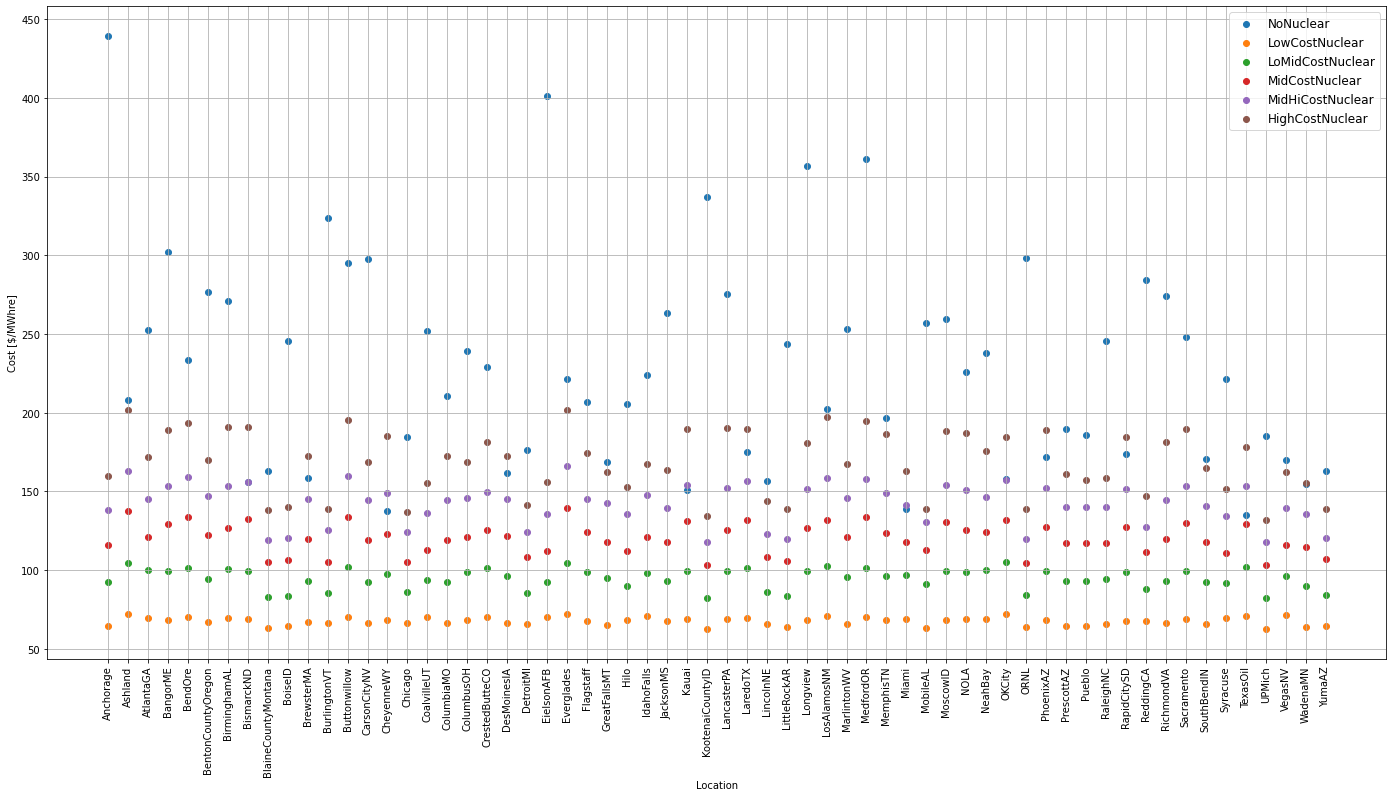

In [10]:
fig = plt.figure()
fig, ax=plt.subplots(figsize=(24,12))
ax.scatter(Case1.index.values,Case1['Cost/COE\n($)']*1000)
ax.scatter(Case1.index.values,Case2['Cost/COE\n($)']*1000)
ax.scatter(Case1.index.values,Case25['Cost/COE\n($)']*1000)
ax.scatter(Case1.index.values,Case3['Cost/COE\n($)']*1000)
ax.scatter(Case1.index.values,Case35['Cost/COE\n($)']*1000)
ax.scatter(Case1.index.values,Case4['Cost/COE\n($)']*1000)
ax.legend(['NoNuclear', 'LowCostNuclear','LoMidCostNuclear', 'MidCostNuclear', 'MidHiCostNuclear','HighCostNuclear'], fontsize='large')
plt.ylabel('Cost [\$/MWhre]')
plt.xlabel('Location')
plt.xticks(rotation=90);
ax.grid(True)


NameError: name 'bars25' is not defined

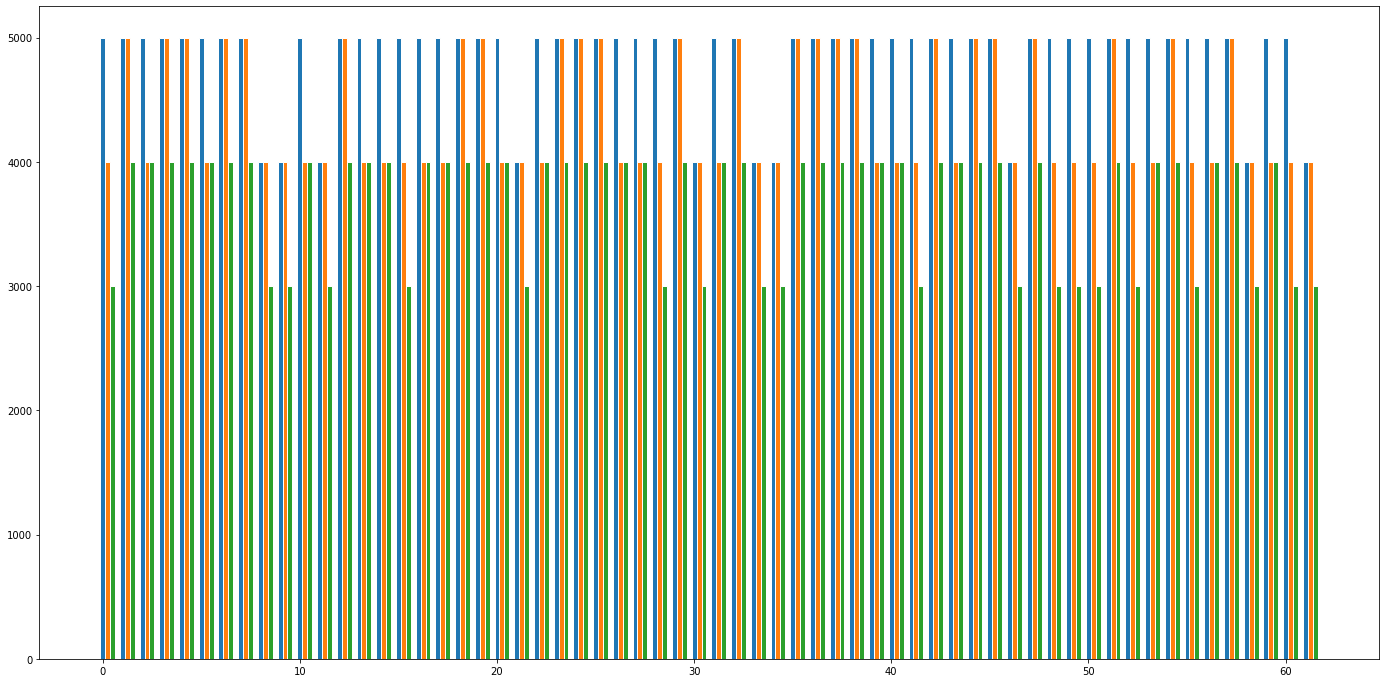

In [11]:
m = len(Case2)
fig = plt.figure(figsize=(24,12))
barWidth = 0.25
# Grabbing Generator Size Data
bars1 = Case2["Architecture/GenLarge\n(kW)"]
bars15 = Case25["Architecture/GenLarge\n(kW)"]
bars2 = Case3["Architecture/GenLarge\n(kW)"]
bars2 = Case35["Architecture/GenLarge\n(kW)"]
bars3 = Case4["Architecture/GenLarge\n(kW)"]
#ranges
r1 = np.arange(m)
r15 = [x+barWidth for x in r1]
r2 = [x+barWidth for x in r15]
r25 = [x+barWidth for x in r2]
r3 = [x+barWidth for x in r25]

# Plotting
plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='LowCostNuclear')
plt.bar(r15, bars15, width=barWidth, edgecolor='white', label='LoMidCostNuclear')
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='MidCostNuclear')
plt.bar(r25, bars25, width=barWidth, edgecolor='white', label='MidCostNuclear')
plt.bar(r3, bars3, width=barWidth, edgecolor='white', label='HighCostNuclear')
# Add xticks on the middle of the group bars
plt.xlabel('Location', fontweight='bold')
plt.ylabel('Microreactor Capacity [MW]', fontweight='bold')
plt.xticks([r + barWidth for r in range(m)], Case2.index.values)
plt.xticks(rotation=90);
plt.grid(True)
 
